<a href="https://colab.research.google.com/github/NitinPrasad5/Active-Learning_Graph-Convolution-Network/blob/main/Active_Learning_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [ ]:
import torch

class SubsetSequentialSampler(torch.utils.data.Sampler):
    r"""Samples elements sequentially from a given list of indices, without replacement.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

# Load DataSet

In [ ]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.datasets import CIFAR100, CIFAR10, FashionMNIST, SVHN, GTSRB

class MyDataset(Dataset):
    def __init__(self, dataset_name, train_flag, transf):
        self.dataset_name = dataset_name
        if self.dataset_name == "cifar10":
            self.cifar10 = CIFAR10('../cifar10', train=train_flag,
                                    download=True, transform=transf)
        if self.dataset_name == "svhn":
            self.svhn = SVHN('../svhn', split="train",
                                    download=True, transform=transf)
        if self.dataset_name == "gtsrb":
            self.gtsrb = GTSRB('../gtsrb', split="train",
                                    download=True, transform=transf)


    def __getitem__(self, index):
        if self.dataset_name == "cifar10":
            data, target = self.cifar10[index]
        if self.dataset_name == "svhn":
            data, target = self.svhn[index]
        if self.dataset_name == "gtsrb":
            data, target = self.gtsrb[index]
        return data, target, index

    def __len__(self):
        if self.dataset_name == "cifar10":
            return len(self.cifar10)
        elif self.dataset_name == "svhn":
            return len(self.svhn)
        elif self.dataset_name == "gtsrb":
            return len(self.gtsrb)

# Data
def load_dataset(dataset):
    target_size = (32, 32)
    train_transform = T.Compose([
        T.Resize(target_size),
        T.RandomHorizontalFlip(),
        T.RandomCrop(size=32, padding=4),
        T.ToTensor(),
        T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
    ])

    test_transform = T.Compose([
        T.Resize(target_size),
        T.ToTensor(),
        T.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) # T.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100
    ])


    if dataset == 'cifar10':
        data_train = CIFAR10('../cifar10', train=True, download=True, transform=train_transform)
        data_unlabeled = MyDataset(dataset, True, test_transform)
        data_test  = CIFAR10('../cifar10', train=False, download=True, transform=test_transform)
        NO_CLASSES = 10
        adden = ADDENDUM
        no_train = NUM_TRAIN

    elif dataset == 'gtsrb':
        data_train = GTSRB('../gtsrb', split='train', download=True, transform=train_transform)
        data_unlabeled = MyDataset(dataset, True, test_transform)
        data_test  = GTSRB('../gtsrb', split='test', download=True, transform=test_transform)
        NO_CLASSES = 43
        adden = ADDENDUM
        no_train = len(data_train)#NUM_TRAIN

    elif dataset == 'svhn':
        data_train = SVHN('../svhn', split='train', download=True,
                                    transform=T.Compose([T.ToTensor()]))
        data_unlabeled = MyDataset(dataset, True, T.Compose([T.ToTensor()]))
        data_test  = SVHN('../svhn', split='test', download=True,
                                    transform=T.Compose([T.ToTensor()]))
        NO_CLASSES = 10
        adden = ADDENDUM
        no_train = NUM_TRAIN
    return data_train, data_unlabeled, data_test, adden, NO_CLASSES, no_train

# Models

## Query Model



In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        self.linear = nn.Linear(nclass, 1)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        feat = F.dropout(x, self.dropout, training=self.training)
        x = self.gc3(feat, adj)
        #x = self.linear(x)
        # x = F.softmax(x, dim=1)
        return torch.sigmoid(x), feat, torch.cat((feat,x),1)


## ResNet

In [ ]:
'''ResNet & VGG in PyTorch.

'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal
import math

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        # self.linear2 = nn.Linear(1000, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out1 = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out = F.avg_pool2d(out4, 4)
        outf = out.view(out.size(0), -1)
        # outl = self.linear(outf)
        out = self.linear(outf)
        return out, outf, [out1, out2, out3, out4]


def ResNet18(num_classes = 10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)


# Selection Method

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
# Custom
# from config import *
# from models.query_models import VAE, Discriminator, GCN
# from data.sampler import SubsetSequentialSampler
# from kcenterGreedy import kCenterGreedy

def BCEAdjLoss(scores, lbl, nlbl, l_adj):
    lnl = torch.log(scores[lbl])
    lnu = torch.log(1 - scores[nlbl])
    labeled_score = torch.mean(lnl)
    unlabeled_score = torch.mean(lnu)
    bce_adj_loss = -labeled_score - l_adj*unlabeled_score
    return bce_adj_loss


def aff_to_adj(x, y=None):
    x = x.detach().cpu().numpy()
    adj = np.matmul(x, x.transpose())
    adj +=  -1.0*np.eye(adj.shape[0])
    adj_diag = np.sum(adj, axis=0) #rowise sum
    adj = np.matmul(adj, np.diag(1/adj_diag))
    adj = adj + np.eye(adj.shape[0])
    adj = torch.Tensor(adj).cuda()

    return adj


def get_features(models, unlabeled_loader):
    models['backbone'].eval()
    with torch.cuda.device(CUDA_VISIBLE_DEVICES):
        features = torch.tensor([]).cuda()
    with torch.no_grad():
            for inputs, _, _ in unlabeled_loader:
                with torch.cuda.device(CUDA_VISIBLE_DEVICES):
                    inputs = inputs.cuda()
                    _, features_batch, _ = models['backbone'](inputs)
                features = torch.cat((features, features_batch), 0)
            feat = features #.detach().cpu().numpy()
    return feat



# Select the indices of the unlablled data according to the methods
def query_samples(model, method, data_unlabeled, subset, labeled_set, cycle, args):

    if method == 'Random':
        arg = np.random.randint(SUBSET, size=SUBSET)

    if method == 'UncertainGCN':
        # Create unlabeled dataloader for the unlabeled subset
        unlabeled_loader = DataLoader(data_unlabeled, batch_size=BATCH,
                sampler=SubsetSequentialSampler(subset+labeled_set), # more convenient if we maintain the order of subset
                                    pin_memory=True)
        binary_labels = torch.cat((torch.zeros([SUBSET, 1]),(torch.ones([len(labeled_set),1]))),0)


        features = get_features(model, unlabeled_loader)
        features = nn.functional.normalize(features)
        adj = aff_to_adj(features)

        gcn_module = GCN(nfeat=features.shape[1],
                         nhid=args.hidden_units,
                         nclass=1,
                         dropout=args.dropout_rate).cuda()

        models      = {'gcn_module': gcn_module}

        optim_backbone = optim.Adam(models['gcn_module'].parameters(), lr=LR_GCN, weight_decay=WDECAY)
        optimizers = {'gcn_module': optim_backbone}
        # if cycle > 0:
        #     lbl = np.arange(SUBSET, SUBSET + ADDENDUM + 200, 1)
        # else:
        #     lbl = np.arange(SUBSET, SUBSET + ADDENDUM, 1)

        lbl = np.arange(SUBSET, SUBSET+(cycle+1)*ADDENDUM, 1)
        nlbl = np.arange(0, SUBSET, 1)

        ############
        for _ in range(200):

            optimizers['gcn_module'].zero_grad()
            outputs, _, _ = models['gcn_module'](features, adj)
            lamda = args.lambda_loss
            loss = BCEAdjLoss(outputs, lbl, nlbl, lamda)
            loss.backward()
            optimizers['gcn_module'].step()


        models['gcn_module'].eval()
        with torch.no_grad():
            with torch.cuda.device(CUDA_VISIBLE_DEVICES):
                inputs = features.cuda()
                labels = binary_labels.cuda()

            scores, _, feat = models['gcn_module'](inputs, adj)

            s_margin = args.s_margin
            scores_median = np.squeeze(torch.abs(scores[:SUBSET] - s_margin).detach().cpu().numpy())
            arg = np.argsort(-(scores_median))

            print("Max confidence value: ",torch.max(scores.data))
            print("Mean confidence value: ",torch.mean(scores.data))
            preds = torch.round(scores)
            correct_labeled = (preds[SUBSET:,0] == labels[SUBSET:,0]).sum().item() / ((cycle+1)*ADDENDUM)
            correct_unlabeled = (preds[:SUBSET,0] == labels[:SUBSET,0]).sum().item() / SUBSET
            correct = (preds[:,0] == labels[:,0]).sum().item() / (SUBSET + (cycle+1)*ADDENDUM)
            print("Labeled classified: ", correct_labeled)
            print("Unlabeled classified: ", correct_unlabeled)
            print("Total classified: ", correct)

    return arg

# Train Test

In [ ]:

import torch
from tqdm import tqdm
import numpy as np
import torchvision.transforms as T
# import models.resnet as resnet


def test(models, epoch, method, dataloaders, mode='val'):
    assert mode == 'val' or mode == 'test'
    models['backbone'].eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in dataloaders[mode]:
            with torch.cuda.device(CUDA_VISIBLE_DEVICES):
                inputs = inputs.cuda()
                labels = labels.cuda()

            scores, _, _ = models['backbone'](inputs)
            _, preds = torch.max(scores.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total

def get_sub_labeled_data(models, epoch, method, dataloaders, mode='val'):
    assert mode == 'val' or mode == 'test'
    models['backbone'].eval()
    data_indices = []
    confidence_scores = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloaders['labeled']):
            sampled_indices = list(dataloaders['labeled'].batch_sampler.sampler.indices)
            indices_in_batch = sampled_indices[batch_idx * BATCH:(batch_idx + 1) * BATCH]
            data_indices += indices_in_batch
            with torch.cuda.device(CUDA_VISIBLE_DEVICES):
                inputs = inputs.cuda()
                labels = labels.cuda()

            scores, _, _ = models['backbone'](inputs)
            _, preds = torch.max(scores.data, 1)
            #predicted_scores = scores[range(len(preds)), preds]
            predicted_scores = [max(scores[i]) for i in range(len(scores))]
            confidence_scores.extend(predicted_scores)

    combined_data = list(zip(data_indices, confidence_scores))
    sorted_data = sorted(combined_data, key=lambda x: x[1])
    sorted_indices = [index for index, _ in sorted_data]
    confidence_scores = [score for index, score in sorted_data]
    print("first 5 comf score: ",confidence_scores[0],confidence_scores[1],confidence_scores[2],confidence_scores[3],confidence_scores[4])
    return sorted_indices


iters = 0
def train_epoch(models, method, criterion, optimizers, dataloaders, epoch, epoch_loss):
    models['backbone'].train()
    if method == 'lloss':
        models['module'].train()
    global iters
    for data in tqdm(dataloaders['train'], leave=False, total=len(dataloaders['train'])):
        with torch.cuda.device(CUDA_VISIBLE_DEVICES):
            inputs = data[0].cuda()
            labels = data[1].cuda()

        iters += 1

        optimizers['backbone'].zero_grad()

        scores, _, features = models['backbone'](inputs)
        target_loss = criterion(scores, labels)

        m_backbone_loss = torch.sum(target_loss) / target_loss.size(0)
        loss = m_backbone_loss

        loss.backward()
        optimizers['backbone'].step()
        if method == 'lloss':
            optimizers['module'].step()
    return loss

def train(models, method, criterion, optimizers, schedulers, dataloaders, num_epochs, epoch_loss):
    print('>> Train a Model.')
    best_acc = 0.

    for epoch in range(num_epochs):

        best_loss = torch.tensor([0.5]).cuda()
        loss = train_epoch(models, method, criterion, optimizers, dataloaders, epoch, epoch_loss)

        schedulers['backbone'].step()
        if method == 'lloss':
            schedulers['module'].step()

        if epoch % 20  == 7:
            acc = test(models, epoch, method, dataloaders, mode='test')
            # acc = test(models, dataloaders, mc, 'test')
            if best_acc < acc:
                best_acc = acc
                print('Val Acc: {:.3f} \t Best Acc: {:.3f}'.format(acc, best_acc))
    print('>> Finished.')

# Config

In [ ]:
''' Configuration File.
'''

CUDA_VISIBLE_DEVICES = 0
NUM_TRAIN = 39208 # N \Fashion MNIST 60000, cifar 10/100 50000
# NUM_VAL   = 50000 - NUM_TRAIN
BATCH     = 128 # B
SUBSET    = 10000 # M
ADDENDUM  = 1000 # K

MARGIN = 1.0 # xi
WEIGHT = 1.0 # lambda

TRIALS = 1
CYCLES = 3

EPOCH = 200
EPOCH_GCN = 200
LR = 3e-1
LR_GCN = 1e-3
MILESTONES = [160, 360,560,760,960]
EPOCHL = 120#20 #120 # After 120 epochs, stop
EPOCHV = 100 # VAAL number of epochs

MOMENTUM = 0.9
WDECAY = 5e-4#2e-3# 5e-4

# Main

In [ ]:
'''
GCN Active Learning
'''

# Python
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as T
import torchvision.models as models
import argparse
# Custom
# import models.resnet as resnet
# from models.resnet import vgg11
# from models.query_models import LossNet
# from train_test import train, test
# from load_dataset import load_dataset
# from selection_methods import query_samples
# from config import *


parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument("-l","--lambda_loss",type=float, default=1.2,
                    help="Adjustment graph loss parameter between the labeled and unlabeled")
parser.add_argument("-s","--s_margin", type=float, default=0.1,
                    help="Confidence margin of graph")
parser.add_argument("-n","--hidden_units", type=int, default=128,
                    help="Number of hidden units of the graph")
parser.add_argument("-r","--dropout_rate", type=float, default=0.3,
                    help="Dropout rate of the graph neural network")
parser.add_argument("-d","--dataset", type=str, default="gtsrb",
                    help="")
parser.add_argument("-e","--no_of_epochs", type=int, default=20,
                    help="Number of epochs for the active learner")
parser.add_argument("-m","--method_type", type=str, default="UncertainGCN",
                    help="")
parser.add_argument("-c","--cycles", type=int, default=4,
                    help="Number of active learning cycles")
parser.add_argument("-t","--total", type=bool, default=False,
                    help="Training on the entire dataset")

args = parser.parse_args()

##
# Main
if __name__ == '__main__':

    method = args.method_type
    methods = ['Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss','VAAL']
    datasets = ['cifar10', 'cifar100', 'fashionmnist','svhn','gtsrb']
    assert method in methods, 'No method %s! Try options %s'%(method, methods)
    assert args.dataset in datasets, 'No dataset %s! Try options %s'%(args.dataset, datasets)
    '''
    method_type: 'Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss','VAAL'
    '''
    results = open('results_'+str(args.method_type)+"_"+args.dataset +'_main'+str(args.cycles)+str(args.total)+'.txt','w')
    print("Dataset: %s"%args.dataset)
    print("Method type:%s"%method)
    if args.total:
        TRIALS = 1
        CYCLES = 1
    else:
        CYCLES = args.cycles
    for trial in range(TRIALS):

        # Load training and testing dataset
        data_train, data_unlabeled, data_test, adden, NO_CLASSES, no_train = load_dataset(args.dataset)
        # Don't predefine budget size. Configure it in the config.py: ADDENDUM = adden
        NUM_TRAIN = no_train
        indices = list(range(NUM_TRAIN))
        random.shuffle(indices)

        if args.total:
            labeled_set= indices
        else:
            labeled_set = indices[:ADDENDUM]
            unlabeled_set = [x for x in indices if x not in labeled_set]

        train_loader = DataLoader(data_train, batch_size=BATCH,
                                    sampler=SubsetRandomSampler(labeled_set),
                                    pin_memory=True, drop_last=True)

        test_loader  = DataLoader(data_test, batch_size=BATCH)

        dataloaders  = {'train': train_loader, 'test': test_loader}

        for cycle in range(CYCLES):

            # Randomly sample 10000 unlabeled data points
            if not args.total:
                random.shuffle(unlabeled_set)
                subset = unlabeled_set[:SUBSET]

            # Model - create new instance for every cycle so that it resets
            with torch.cuda.device(CUDA_VISIBLE_DEVICES):
                resnet18 = ResNet18(num_classes=NO_CLASSES).cuda()

            models = {'backbone': resnet18}

            # Loss, criterion and scheduler (re)initialization
            criterion      = nn.CrossEntropyLoss(reduction='none')
            optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR,
                momentum=MOMENTUM, weight_decay=WDECAY)

            sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES)
            optimizers = {'backbone': optim_backbone}
            schedulers = {'backbone': sched_backbone}

            # Training and testing
            train(models, method, criterion, optimizers, schedulers, dataloaders, args.no_of_epochs, EPOCHL)
            acc = test(models, EPOCH, method, dataloaders, mode='test')
            print('Trial {}/{} || Cycle {}/{} || Label set size {}: Test acc {}'.format(trial+1, TRIALS, cycle+1, CYCLES, len(labeled_set), acc))
            np.array([method, trial+1, TRIALS, cycle+1, CYCLES, len(labeled_set), acc]).tofile(results, sep=" ")
            results.write("\n")


            if cycle == (CYCLES-1):
                # Reached final training cycle
                print("Finished.")
                break
            # Get the indices of the unlabeled samples to train on next cycle
            arg = query_samples(models, method, data_unlabeled, subset, labeled_set, cycle, args)

            # Update the labeled dataset and the unlabeled dataset, respectively
            sampled_from_labeled = get_sub_labeled_data(models, EPOCH, method, dataloaders, mode='test')
            labeled_set = list(torch.tensor(subset)[arg][-ADDENDUM:].numpy()) + sampled_from_labeled[:200]
            listd = list(torch.tensor(subset)[arg][:-ADDENDUM].numpy())
            unlabeled_set = listd + unlabeled_set[SUBSET:]
            print(len(labeled_set), min(labeled_set), max(labeled_set))
            # Create a new dataloader for the updated labeled dataset
            dataloaders['train'] = DataLoader(data_train, batch_size=BATCH,
                                            sampler=SubsetRandomSampler(labeled_set),
                                            pin_memory=True)

    results.close()

import shutil

# Define the destination directory in Google Drive
drive_directory_cifar = "/content/drive/MyDrive/B.Tech./4th year/sem1/AML/Assignment1/Programming_Assignment/Results_CIFAR10"
drive_directory_cifar = "/content/drive/MyDrive/B.Tech./4th year/sem1/AML/Assignment1/Programming_Assignment/Results_GTSRB"

result_file_path = 'content/results_'+str(args.method_type)+"_"+args.dataset +'_main'+str(args.cycles)+str(args.total)+'.txt'

# Copy the file to the destination directory in Google Drive
if(args.dataset == 'cifar10'):
    shutil.copy(file_path, drive_directory_cifar)
elif(args.dataset == 'gtsrb'):
    shutil.copy(file_path, drive_directory_gtsrb)


#Transfer learning

In [ ]:
'''
GCN Active Learning
'''

# Python
import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as T
import torchvision.models as models
import argparse
# Custom
# import models.resnet as resnet
# from models.resnet import vgg11
# from models.query_models import LossNet
# from train_test import train, test
# from load_dataset import load_dataset
# from selection_methods import query_samples
# from config import *


parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument("-l","--lambda_loss",type=float, default=1.2,
                    help="Adjustment graph loss parameter between the labeled and unlabeled")
parser.add_argument("-s","--s_margin", type=float, default=0.1,
                    help="Confidence margin of graph")
parser.add_argument("-n","--hidden_units", type=int, default=128,
                    help="Number of hidden units of the graph")
parser.add_argument("-r","--dropout_rate", type=float, default=0.3,
                    help="Dropout rate of the graph neural network")
parser.add_argument("-d","--dataset", type=str, default="gtsrb",
                    help="")
parser.add_argument("-e","--no_of_epochs", type=int, default=200,
                    help="Number of epochs for the active learner")
parser.add_argument("-m","--method_type", type=str, default="UncertainGCN",
                    help="")
parser.add_argument("-c","--cycles", type=int, default=10,
                    help="Number of active learning cycles")
parser.add_argument("-t","--total", type=bool, default=False,
                    help="Training on the entire dataset")

args = parser.parse_args()

##
# Main
if __name__ == '__main__':

    method = args.method_type
    methods = ['Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss','VAAL']
    datasets = ['cifar10', 'cifar100', 'fashionmnist','svhn','gtsrb']
    assert method in methods, 'No method %s! Try options %s'%(method, methods)
    assert args.dataset in datasets, 'No dataset %s! Try options %s'%(args.dataset, datasets)
    '''
    method_type: 'Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss','VAAL'
    '''
    results = open('results_'+str(args.method_type)+"_"+args.dataset +'_main'+str(args.cycles)+str(args.total)+'.txt','w')
    print("Dataset: %s"%args.dataset)
    print("Method type:%s"%method)
    if args.total:
        TRIALS = 1
        CYCLES = 1
    else:
        CYCLES = args.cycles
    for trial in range(TRIALS):

        # Load training and testing dataset
        data_train, data_unlabeled, data_test, adden, NO_CLASSES, no_train = load_dataset(args.dataset)
        # Don't predefine budget size. Configure it in the config.py: ADDENDUM = adden
        NUM_TRAIN = no_train
        indices = list(range(NUM_TRAIN))
        random.shuffle(indices)

        if args.total:
            labeled_set= indices
        else:
            labeled_set = indices[:ADDENDUM]
            labeled_set_till_now = labeled_set
            unlabeled_set = [x for x in indices if x not in labeled_set]

        train_loader = DataLoader(data_train, batch_size=BATCH,
                                    sampler=SubsetRandomSampler(labeled_set),
                                    pin_memory=True, drop_last=True)

        test_loader  = DataLoader(data_test, batch_size=BATCH)

        labeled_loader = DataLoader(data_train, batch_size=BATCH,
                                    sampler=SubsetRandomSampler(labeled_set_till_now),
                                    pin_memory=True, drop_last=True)

        dataloaders  = {'train': train_loader, 'test': test_loader, 'labeled': labeled_loader}

        # Model - create new instance for every cycle so that it resets
        with torch.cuda.device(CUDA_VISIBLE_DEVICES):
            resnet18 = ResNet18(num_classes=NO_CLASSES).cuda()

        models = {'backbone': resnet18}

        # Loss, criterion and scheduler (re)initialization
        criterion      = nn.CrossEntropyLoss(reduction='none')
        optim_backbone = optim.SGD(models['backbone'].parameters(), lr=LR,
            momentum=MOMENTUM, weight_decay=WDECAY)

        sched_backbone = lr_scheduler.MultiStepLR(optim_backbone, milestones=MILESTONES, gamma = 0.5)
        optimizers = {'backbone': optim_backbone}
        schedulers = {'backbone': sched_backbone}

        for cycle in range(CYCLES):

            # Randomly sample 10000 unlabeled data points
            if not args.total:
                random.shuffle(unlabeled_set)
                subset = unlabeled_set[:SUBSET]

            # Training and testing
            train(models, method, criterion, optimizers, schedulers, dataloaders, args.no_of_epochs, EPOCHL)
            acc = test(models, EPOCH, method, dataloaders, mode='test')
            print('Trial {}/{} || Cycle {}/{} || Label set size {}: Test acc {}'.format(trial+1, TRIALS, cycle+1, CYCLES, len(labeled_set), acc))
            np.array([method, trial+1, TRIALS, cycle+1, CYCLES, len(labeled_set), acc]).tofile(results, sep=" ")
            results.write("\n")


            if cycle == (CYCLES-1):
                # Reached final training cycle
                print("Finished.")
                break
            # Get the indices of the unlabeled samples to train on next cycle
            arg = query_samples(models, method, data_unlabeled, subset, labeled_set_till_now, cycle, args)

            # Update the labeled dataset and the unlabeled dataset, respectively
            sampled_from_labeled = get_sub_labeled_data(models, EPOCH, method, dataloaders, mode='test')
            labeled_set = list(torch.tensor(subset)[arg][-ADDENDUM:].numpy()) + sampled_from_labeled[:int(0.25*len(labeled_set_till_now))]
            labeled_set_till_now += list(torch.tensor(subset)[arg][-ADDENDUM:].numpy())
            listd = list(torch.tensor(subset)[arg][:-ADDENDUM].numpy())
            unlabeled_set = listd + unlabeled_set[SUBSET:]
            print(len(labeled_set), min(labeled_set), max(labeled_set))
            # Create a new dataloader for the updated labeled dataset
            dataloaders['train'] = DataLoader(data_train, batch_size=BATCH,
                                            sampler=SubsetRandomSampler(labeled_set),
                                            pin_memory=True)

    results.close()

Dataset: gtsrb
Method type:UncertainGCN
>> Train a Model.


Val Acc: 7.688 	 Best Acc: 7.688


Val Acc: 15.503 	 Best Acc: 15.503


Val Acc: 18.068 	 Best Acc: 18.068


Val Acc: 40.340 	 Best Acc: 40.340


Val Acc: 41.188 	 Best Acc: 41.188


Val Acc: 48.741 	 Best Acc: 48.741


Val Acc: 71.607 	 Best Acc: 71.607


Val Acc: 75.859 	 Best Acc: 75.859


>> Finished.
Trial 1/1 || Cycle 1/10 || Label set size 1000: Test acc 76.41330166270784
first 5 comf score:  tensor(8.7798, device='cuda:0') tensor(9.1963, device='cuda:0') tensor(9.2943, device='cuda:0') tensor(9.3665, device='cuda:0') tensor(9.3794, device='cuda:0')
1250 84 26615
>> Train a Model.


Val Acc: 69.913 	 Best Acc: 69.913


Val Acc: 71.433 	 Best Acc: 71.433


Val Acc: 74.576 	 Best Acc: 74.576


Val Acc: 79.477 	 Best Acc: 79.477


Val Acc: 85.867 	 Best Acc: 85.867


Val Acc: 87.379 	 Best Acc: 87.379


>> Finished.
Trial 1/1 || Cycle 2/10 || Label set size 1250: Test acc 87.34758511480602
Max confidence value:  tensor(0.8237, device='cuda:0')
Mean confidence value:  tensor(0.4273, device='cuda:0')
Labeled classified:  0.4305
Unlabeled classified:  0.8279
Total classified:  0.7616666666666667
first 5 comf score:  tensor(2.6027, device='cuda:0') tensor(3.3345, device='cuda:0') tensor(3.8747, device='cuda:0') tensor(3.8804, device='cuda:0') tensor(3.9254, device='cuda:0')
1500 0 26575
>> Train a Model.


Val Acc: 84.964 	 Best Acc: 84.964


Val Acc: 90.245 	 Best Acc: 90.245


# Plots
run this cell only when you have run the above scripts for the dataset and have the results.txt files in your folders

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
methods = ['Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss']
columns = ['method','trial','tota_trial','cycle','total_cycle','label_set_size','accuracy']

## CIFAR10
dataset used in the paper

Text(0.5, 1.0, 'Results cifar10')

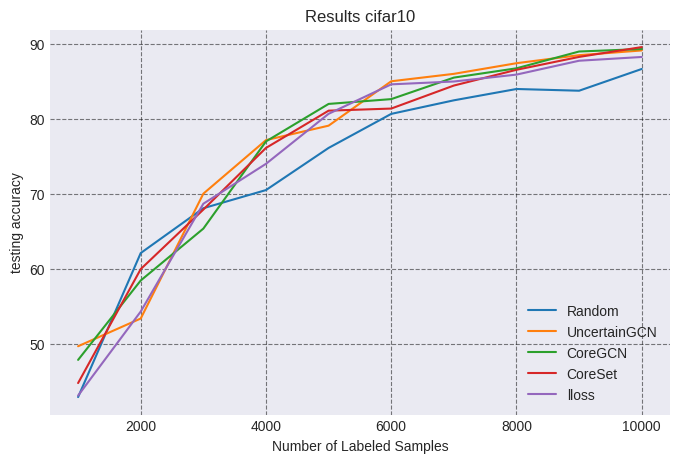

In [ ]:
folder_path = '/content/drive/MyDrive/B.Tech./4th year/sem1/AML/Assignment1/Programming_Assignment/Results_CIFAR10'
dataset = 'cifar10'

plt.figure(figsize=(8,5), facecolor='w',edgecolor='k')
for method in methods:
    path = folder_path + '/results_{}_{}_main10False.txt'.format(method,dataset)

    results = pd.read_csv(path, sep = ' ', names = columns)
    results['accuracy'] = results['accuracy'].str.replace("'", '').astype(np.float64)
    results['cycle'] = results['cycle'].str.replace("'", '').astype(np.int64)
    plt.plot(results['cycle']*1000, results['accuracy'])


plt.grid(True, alpha=0.5, color='k', linestyle='--',)
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Testing Accuracy')
plt.legend(['Random', 'UncertainGCN', 'CoreGCN', 'CoreSet', 'lloss'],loc = 'lower right')
plt.title('Results {}'.format(dataset))

## GTSRB
dataset which I have used

Text(0.5, 1.0, 'Results gtsrb')

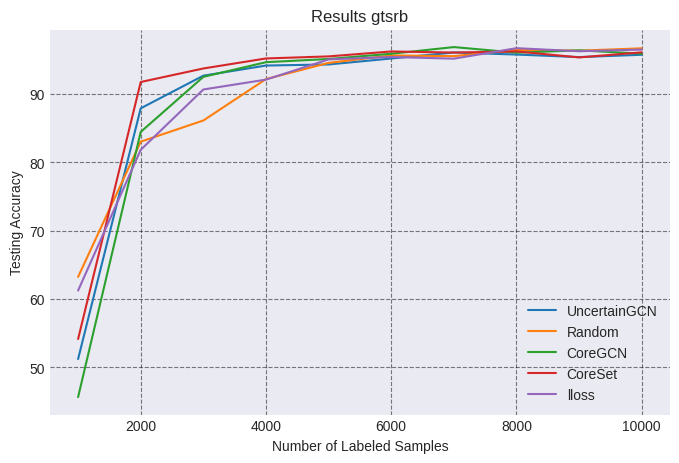

In [ ]:
folder_path = '/content/drive/MyDrive/B.Tech./4th year/sem1/AML/Assignment1/Programming_Assignment/Results_GTSRB'
dataset = 'gtsrb'

plt.figure(figsize=(8,5))
for method in methods:
    path = folder_path + '/results_{}_{}_main10False.txt'.format(method,dataset)
    results = pd.read_csv(path, sep = ' ', names = columns)
    results['accuracy'] = results['accuracy'].str.replace("'", '').astype(np.float64)
    results['cycle'] = results['cycle'].str.replace("'", '').astype(np.int64)
    plt.plot(results['cycle']*1000, results['accuracy'])

plt.grid(True, alpha=0.5, color='k', linestyle='--',)
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Testing Accuracy')
plt.legend(['UncertainGCN', 'Random', 'CoreGCN', 'CoreSet', 'lloss'],loc = 'lower right')
plt.title('Results {}'.format(dataset))

# On Modified algorithm

Text(0.5, 1.0, 'Results gtsrb')

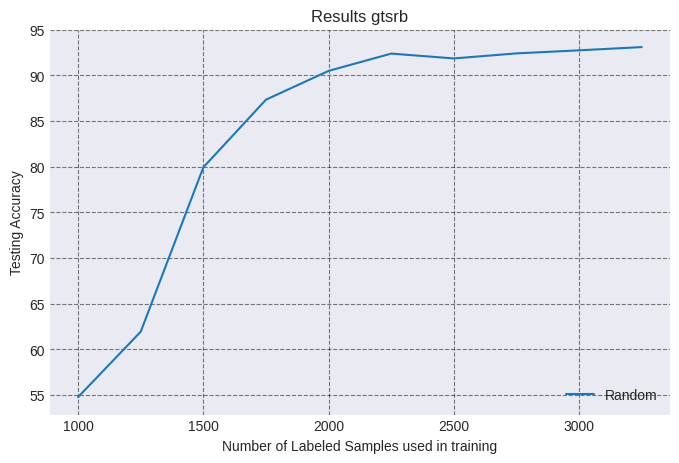

In [ ]:
folder_path = '/content/drive/MyDrive/B.Tech./4th year/sem1/AML/Assignment1/Programming_Assignment/Results_Modified_Algorithm/Results_GTSRB'
dataset = 'gtsrb'

methods = ['UncertainGCN']

plt.figure(figsize=(8,5))
for method in methods:
    path = folder_path + '/results_{}_{}_main10False.txt'.format(method,dataset)
    results = pd.read_csv(path, sep = ' ', names = columns)
    results['accuracy'] = results['accuracy'].str.replace("'", '').astype(np.float64)
    results['label_set_size'] = results['label_set_size'].str.replace("'", '').astype(np.int64)
    plt.plot(results['label_set_size'], results['accuracy'])

plt.grid(True, alpha=0.5, color='k', linestyle='--',)
plt.xlabel('Number of Labeled Samples used in training')
plt.ylabel('Testing Accuracy')
plt.legend([ 'Random','UncertainGCN'],loc = 'lower right')
plt.title('Results {}'.format(dataset))